# Plant Disease Detection — Kaggle-ready (safer, lightweight)

Instructions (quick):
1. Upload this notebook to Kaggle and open it.
2. If needed, enable GPU in **Settings** (GPU recommended but not required).
3. **Run the first cell** (it may install `protobuf`); after that **Restart the session** (Run → Restart & clear cell outputs) and then run the notebook cells from top to bottom.

Notes: this version uses smaller image size and MobileNetV2 to avoid GPU/RAM hangs and **does not use `.cache()`** to prevent the kernel from freezing on large datasets.


In [ ]:
# Cell 1 — Fix protobuf if needed (run this ONCE, then restart the session)
# If you already pinned protobuf earlier on this machine, you can skip this cell.
# Run this cell, then: Menu -> Run -> Restart & clear cell outputs, then run the rest of the notebook.

import sys
print('Python', sys.version)
# Install protobuf compatible with TF to avoid MessageFactory/GetPrototype errors
# This will print warnings about dependency conflicts on Kaggle; that's expected and safe.
!pip install -q protobuf==3.20.3
!pip show protobuf

print('\nAfter this cell completes, please restart the Kaggle session (Run -> Restart & clear cell outputs)')


In [12]:
# Cell 2 - imports and TF configuration
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Safe GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except Exception:
        pass


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [13]:
# Cell 3 - dataset detection and safe defaults
# Original uploaded notebook path (for your reference): /mnt/data/Plant_Disease_Detection.ipynb

possible_roots = [
    '/kaggle/input/plantvillage/PlantVillage',
    '/kaggle/input/plantvillage/PlantVillage',
    '/kaggle/input/plantvillage'
]
ROOT = None
for p in possible_roots:
    if os.path.exists(p):
        ROOT = p
        break
if ROOT is None:
    raise FileNotFoundError("Dataset not found. Edit this cell with the correct path.")

# Prefer structure with train/val subfolders
if os.path.isdir(os.path.join(ROOT, 'train')) and os.path.isdir(os.path.join(ROOT, 'val')):
    TRAIN_DIR = os.path.join(ROOT, 'train')
    VAL_DIR   = os.path.join(ROOT, 'val')
else:
    # If your dataset is laid out differently, set TRAIN_DIR and VAL_DIR manually below
    TRAIN_DIR = os.path.join(ROOT, 'train')   # fallback
    VAL_DIR   = os.path.join(ROOT, 'val')     # fallback

print('TRAIN_DIR =', TRAIN_DIR)
print('VAL_DIR   =', VAL_DIR)

# Safety/defaults (tune later)
IMG_SIZE = (224, 224)    # EfficientNetB0 standard (224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


TRAIN_DIR = /kaggle/input/plantvillage/PlantVillage/train
VAL_DIR   = /kaggle/input/plantvillage/PlantVillage/val


In [14]:
# Cell 4 - create datasets using image_dataset_from_directory and proper EfficientNet preprocess
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES, class_names[:10])

# Preprocess function (EfficientNet expects float scaled according to its preprocess)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
def preprocess_fn(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

train_ds = raw_train_ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = raw_val_ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# quick sanity check
for imgs, lbls in train_ds.take(1):
    print("batch images:", imgs.shape, imgs.dtype)
    print("batch labels:", lbls.shape, lbls.dtype)
    break



Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.
Classes: 38 ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']
batch images: (32, 224, 224, 3) <dtype: 'float32'>
batch labels: (32,) <dtype: 'int32'>


In [15]:
# Cell 5 - compute class weights from the training dataset (so class imbalance is handled)
# Try to extract labels quickly from raw_train_ds
train_labels_list = []
for _, lbls in raw_train_ds.unbatch():
    train_labels_list.append(int(lbls.numpy()))
train_labels_arr = np.array(train_labels_list)
class_weights_arr = compute_class_weight('balanced', classes=np.unique(train_labels_arr), y=train_labels_arr)
class_weights = {int(i): float(w) for i, w in enumerate(class_weights_arr)}
print("Class weights sample:", list(class_weights.items())[:6])


Class weights sample: [(0, 2.268379281537176), (1, 2.3049660441426147), (2, 5.196650717703349), (3, 0.8687410014397696), (4, 0.9511340747876347), (5, 1.3577947243405426)]


In [16]:
# Cell 6 - EfficientNetB0 model (transfer learning)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SIZE+(3,))
base_model.trainable = False   # freeze for head training

inputs = keras.Input(shape=IMG_SIZE+(3,))
x = inputs
# small on-the-fly augmentation; optional
x = layers.RandomFlip('horizontal')(x)
x = layers.RandomRotation(0.06)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,724,937 (18.02 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
# Cell 7 - compile and callbacks (fixed for Kaggle TF version)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

CHECKPOINT = '/kaggle/working/plant_disease_effb0_best.keras'  # will save native format automatically

callbacks = [
    ModelCheckpoint(
        CHECKPOINT,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )
]

In [ ]:
# Cell 8 - train head
EPOCHS_HEAD = 30   # tune as you want; callbacks will stop earlier if needed
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30


E0000 00:00:1763971946.975421      79 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7570 - loss: 0.9154
Epoch 1: val_accuracy improved from -inf to 0.94798, saving model to /kaggle/working/plant_disease_effb0_best.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 150s 98ms/step - accuracy: 0.7571 - loss: 0.9151 - val_accuracy: 0.9480 - val_loss: 0.1585 - learning_rate: 0.0010
Epoch 2/30
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9122 - loss: 0.2677
Epoch 2: val_accuracy improved from 0.94798 to 0.95479, saving model to /kaggle/working/plant_disease_effb0_best.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 126s 93ms/step - accuracy: 0.9122 - loss: 0.2676 - val_accuracy: 0.9548 - val_loss: 0.1336 - learning_rate: 0.0010
Epoch 3/30
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9272 - loss: 0.2208
Epoch 3: val_accuracy improved from 0.95479 to 0.95949, saving model to /kaggle/working/plant_disease_effb0_best.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 126s 93ms/step - accuracy: 0.9272 - loss: 0.2208 - val_accuracy: 0.

In [22]:
import tensorflow as tf

# Load the best saved model from checkpoint
checkpoint_path = '/kaggle/working/plant_disease_effb0_best.keras'
model = tf.keras.models.load_model(checkpoint_path)

print("Model loaded from checkpoint:", checkpoint_path)

Model loaded from checkpoint: /kaggle/working/plant_disease_effb0_best.keras


In [23]:
# Assuming model is already loaded from the checkpoint

# Number of additional epochs to run (just to finish up)
additional_epochs = 2

# Continue training from where you left off
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=additional_epochs,
    callbacks=callbacks
)

Epoch 1/2


E0000 00:00:1763977431.186376      79 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9823 - loss: 0.0480
Epoch 1: val_accuracy did not improve from 0.98600
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 96ms/step - accuracy: 0.9823 - loss: 0.0480 - val_accuracy: 0.9859 - val_loss: 0.0450 - learning_rate: 6.2500e-05
Epoch 2/2
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9828 - loss: 0.0492
Epoch 2: val_accuracy did not improve from 0.98600
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 125s 92ms/step - accuracy: 0.9828 - loss: 0.0492 - val_accuracy: 0.9855 - val_loss: 0.0457 - learning_rate: 6.2500e-05
Restoring model weights from the end of the best epoch: 1.


In [24]:
# Cell 9 - fine-tune
base_model.trainable = True
# Freeze early layers, unfreeze top layers for fine-tuning
fine_tune_at = len(base_model.layers) - 40  # adjust e.g., last 40 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 20
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD + EPOCHS_FINE,
    initial_epoch=history_head.epoch[-1] + 1,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 31/50


E0000 00:00:1763977726.836639      79 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9821 - loss: 0.0534
Epoch 31: val_accuracy did not improve from 0.98600
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 96ms/step - accuracy: 0.9821 - loss: 0.0534 - val_accuracy: 0.9857 - val_loss: 0.0440 - learning_rate: 1.0000e-05
Epoch 32/50
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9850 - loss: 0.0452
Epoch 32: val_accuracy did not improve from 0.98600
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 126s 92ms/step - accuracy: 0.9850 - loss: 0.0453 - val_accuracy: 0.9858 - val_loss: 0.0447 - learning_rate: 1.0000e-05
Epoch 33/50
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9826 - loss: 0.0487
Epoch 33: val_accuracy did not improve from 0.98600
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 125s 92ms/step - accuracy: 0.9826 - loss: 0.0487 - val_accuracy: 0.9859 - val_loss: 0.0451 - learning_rate: 1.0000e-05
Epoch 34/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9834 - loss: 0.0457
Epoch 34: val_accuracy did not improve from 0.

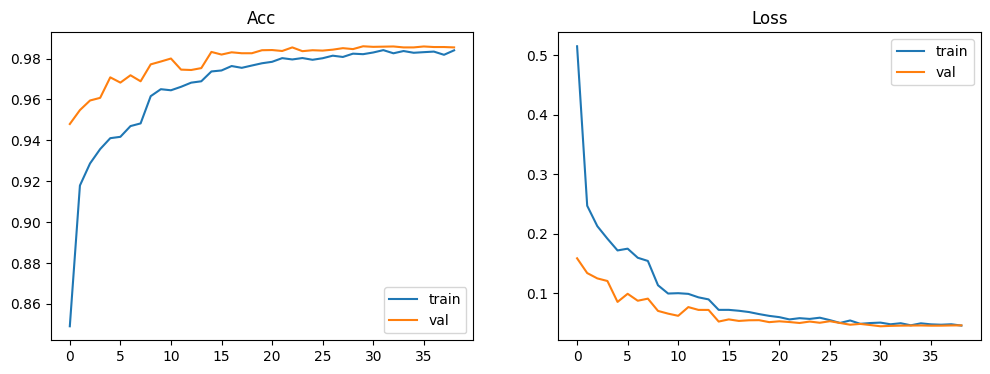

In [25]:
# Cell 10 - plot combined training history
import matplotlib.pyplot as plt

def combine_and_plot(h1, h2=None):
    acc = h1.history['accuracy']; val_acc = h1.history['val_accuracy']
    loss = h1.history['loss']; val_loss = h1.history['val_loss']
    if h2 is not None:
        acc = acc + h2.history['accuracy']; val_acc = val_acc + h2.history['val_accuracy']
        loss = loss + h2.history['loss']; val_loss = val_loss + h2.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(epochs, acc, label='train'); plt.plot(epochs, val_acc, label='val'); plt.legend(); plt.title('Acc')
    plt.subplot(1,2,2); plt.plot(epochs, loss, label='train'); plt.plot(epochs, val_loss, label='val'); plt.legend(); plt.title('Loss')
    plt.show()

try:
    combine_and_plot(history_head, history_fine)
except NameError:
    combine_and_plot(history_head)

Loading best checkpoint: /kaggle/working/plant_disease_effb0_best.keras
test_ds not found -> evaluating on val_ds
340/340 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9898 - loss: 0.0360
Evaluate (loss, acc): [0.04610487446188927, 0.9860049486160278]

Classification report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       126
                                 Apple___Black_rot       0.98      1.00      0.99       125
                          Apple___Cedar_apple_rust       0.98      1.00      0.99        55
                                   Apple___healthy       0.99      0.99      0.99       329
                               Blueberry___healthy       0.99      1.00      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      0.99    

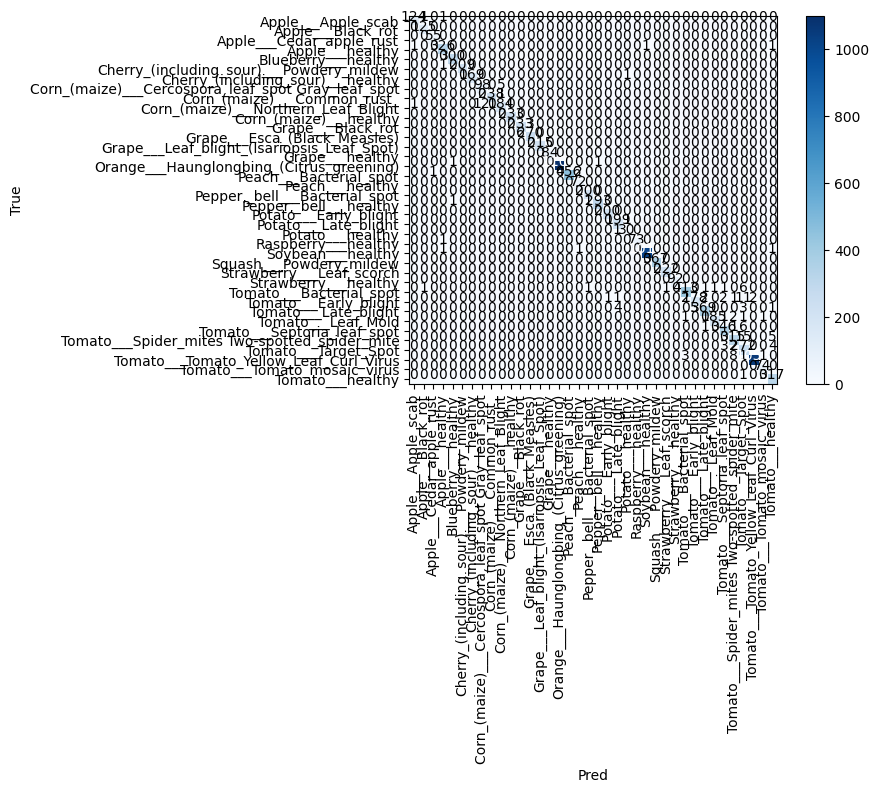

Saved predictions to /kaggle/working/predictions_effb0.csv


In [26]:
# Cell 11 - final evaluation + classification report + confusion matrix + CSV of preds
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import itertools, matplotlib.pyplot as plt

# load best model if checkpoint exists
if os.path.exists(CHECKPOINT):
    print("Loading best checkpoint:", CHECKPOINT)
    model = tf.keras.models.load_model(CHECKPOINT)
else:
    print("No checkpoint found; using current in-memory model.")

# Choose evaluation dataset: prefer 'test_ds' if you created it earlier, else use val_ds
if 'test_ds' in globals():
    eval_ds = test_ds
    print("Evaluating on test_ds")
else:
    eval_ds = val_ds
    print("test_ds not found -> evaluating on val_ds")

# Evaluate
res = model.evaluate(eval_ds, verbose=1)
print("Evaluate (loss, acc):", res)

# Predict for detailed metrics
y_true = []; y_pred = []
for images, labels in eval_ds.unbatch().batch(128):
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

# Ensure class_names is available
if 'class_names' not in globals():
    class_names = [f"class_{i}" for i in range(len(set(y_true)))]

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8)); plt.imshow(cm, cmap=plt.cm.Blues); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90); plt.yticks(ticks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# Save predictions CSV
out = pd.DataFrame({
    "true_idx": y_true,
    "pred_idx": y_pred,
    "true_label": [class_names[i] for i in y_true],
    "pred_label": [class_names[i] for i in y_pred]
})
out_path = '/kaggle/working/predictions_effb0.csv'
out.to_csv(out_path, index=False)
print("Saved predictions to", out_path)


In [27]:
# Cell 12 - save the final model (native Keras format)
final_path = '/kaggle/working/plant_disease_effb0_final.keras'
model.save(final_path)
print("Saved final model to", final_path)

Saved final model to /kaggle/working/plant_disease_effb0_final.keras


### Notes
- If Kaggle still hangs, reduce `IMG_SIZE` to (96,96) and `BATCH_SIZE` to 8.
- To speed up experimentation use `EPOCHS = 4`.
- If you pinned protobuf already in the session, skip the protobuf cell.
